# 📌 Introduction

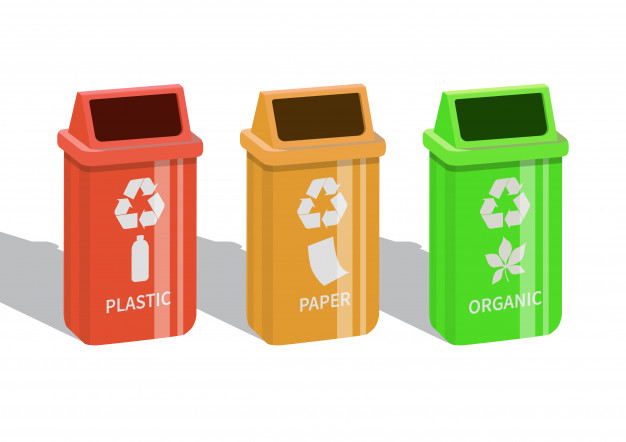

Waste is a significant global issue. Increasing volumes of waste are being generated as the global population and living standards rise. People are increasingly concerned about the production of waste and its effect, and are seeking ways to deal with the problem.

Recycling is the process of converting waste materials into new materials and objects. The recovery of energy from waste materials is often included in this concept. The recyclability of a material depends on its ability to reacquire the properties it had in its original state. It is an alternative to "conventional" waste disposal that can save material and help lower greenhouse gas emissions. Recycling can prevent the waste of potentially useful materials and reduce the consumption of fresh raw materials, thereby reducing: energy usage, air pollution (from incineration), and water pollution (from landfilling).

 **🟢 In this notebook, we will classify waste as organic or recyclable using Convolutional Neural Network (CNN).**

In [143]:
%pip install opencv-python

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/v/anaconda3/lib/python3.11/site-packages/pip/__main__.py", line 8, in <module>
    if sys.path[0] in ("", os.getcwd()):
                           ^^^^^^^^^^^
PermissionError: [Errno 1] Operation not permitted
Note: you may need to restart the kernel to use updated packages.


In [144]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, _ in os.walk('DATASET'):
        print(dirname)

In [145]:
train_path = "DATASET/TRAIN"
test_path = "DATASET/TEST/"

## Import Libraries

In [146]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from glob import glob

## Visualization

In [147]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

In [148]:
data.shape

(0, 2)

In [149]:
from collections import Counter
Counter(y_data)

Counter()

ValueError: 'label' must be of length 'x'

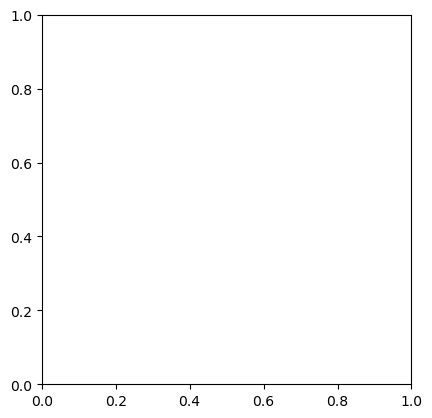

In [150]:
colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Not Recyclable', 'Recyclable'], colors= colors,radius=2)
plt.show()

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


# Convolutional Neural Network - CNN

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

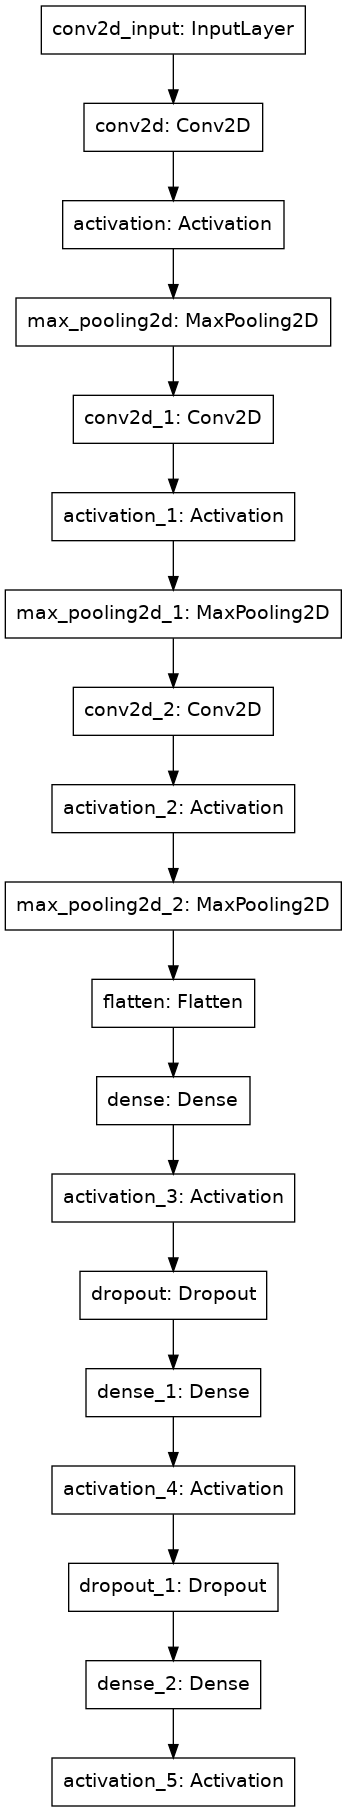

In [ ]:
plot_model(model)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

Found 4 images belonging to 2 classes.
Found 5 images belonging to 2 classes.


In [ ]:
hist = model.fit_generator(
        generator = train_generator,
        epochs=10,
        validation_data = test_generator)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6650 - accuracy: 0.7500 - val_loss: 1.2662 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 1s 574ms/step - loss: 2.7713 - accuracy: 0.2500 - val_loss: 1.7414 - val_accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 1s 538ms/step - loss: 4.8003 - accuracy: 0.5000 - val_loss: 1.0649 - val_accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 1s 580ms/step - loss: 2.6162 - accuracy: 0.2500 - val_loss: 0.6789 - val_accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 1s 583ms/step - loss: 0.8619 - accuracy: 0.5000 - val_loss: 0.6754 - val_accuracy: 0.6000
Epoch 6/10
1/1 [==============================] - 1s 628ms/step - loss: 0.7660 - accuracy: 0.5000 - val_loss: 0.6862 - val_accuracy: 0.6000
Epoch 7/10
1/1 [==============================] - 1s 684ms/step - loss: 0.7138 - accuracy: 0.5000 - val_loss: 0.6858 - val_accuracy: 0.6000
Epoch 8/10
1/1 [=======

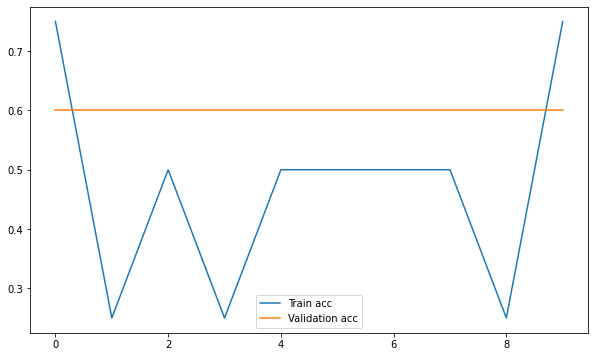

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

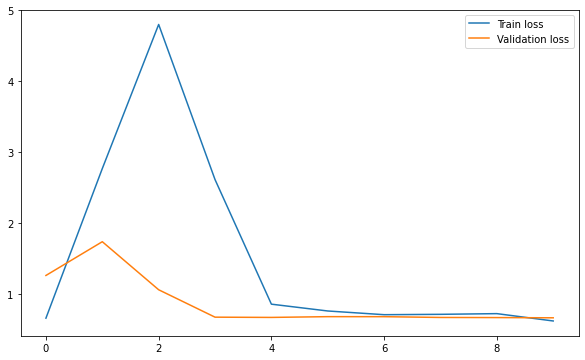

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## Model Prediction

In [ ]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Not Recyclable"+"\033[0m")

This image -> Recyclable


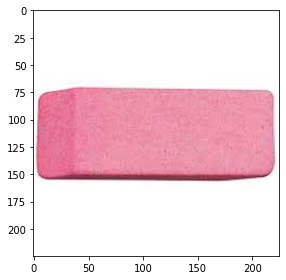

In [ ]:
test_img = cv2.imread("../input/fewshotrecycling/Recycling/TEST/N/eraser.jpeg")
predict_func(test_img)

This image -> Recyclable


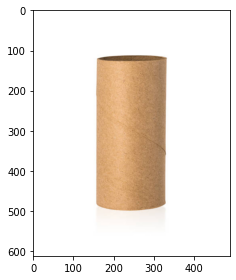

In [ ]:
test_img2 = cv2.imread("../input/fewshotrecycling/Recycling/TEST/Y/toilet_roll.jpeg")
predict_func(test_img2)

This image -> Recyclable


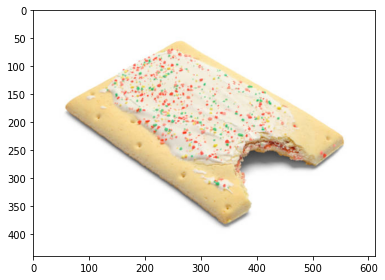

In [ ]:
test_img3 = cv2.imread("../input/fewshotrecycling/Recycling/TEST/N/poptart.jpeg")
predict_func(test_img3)

This image -> Recyclable


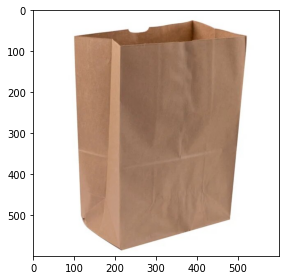

In [ ]:
test_img4 = cv2.imread("../input/fewshotrecycling/Recycling/TEST/Y/bag.jpg")
predict_func(test_img4)

This image -> Recyclable


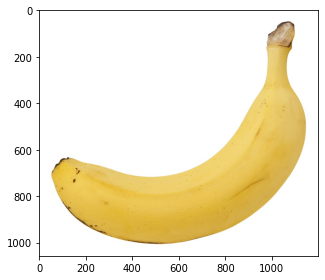

In [ ]:
test_img5 = cv2.imread("../input/fewshotrecycling/Recycling/TEST/N/banane.jpeg")
predict_func(test_img5)